In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from typing import Dict, List, Tuple
from tensorflow.keras import layers, models
from typing import List, Dict, Tuple, Optional
from pathlib import Path



In [2]:
df = pd.read_csv("/Users/sohinikar/FL/M.Tech_Dissertation/Obfuscated-MalMem2022_train_and_test.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
1,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
2,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign
4,Benign,40,12,13.800000,0,306.950000,2082,52.050000,12278,306.950000,...,222,26,27,118,0,123,88,0,8,Benign


In [3]:
df.shape

(52708, 57)

In [4]:
df.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,5.270800e+04,52708.000000,52708.0,...,52708.000000,52708.000000,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,52708.000000
mean,41.398972,14.721731,11.338282,0.0,247.386149,1810.511023,43.694839,1.025501e+04,249.447942,0.0,...,391.341011,221.405916,25.996338,25.059308,116.877552,0.0,121.994574,86.903127,0.000797,7.999886
std,5.779682,2.655174,1.587059,0.0,116.714088,329.846663,5.737274,5.066323e+03,153.023360,0.0,...,4.522731,1.985979,0.165994,1.528529,1.553418,0.0,2.825147,3.134089,0.028217,0.010669
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.971429,0.0,208.700000,1556.000000,38.829268,8.393000e+03,209.634146,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.759132,1730.000000,42.731409,9.275500e+03,246.794279,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.858038,0.0,289.728806,2087.000000,49.563324,1.219200e+04,291.287373,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [5]:
df.shape

(52708, 57)

# Data Cleaning

In [6]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [7]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [9]:
df['Class'] = df['Class'].map({'Benign': 0, 'Malware': 1}) if df['Class'].dtype == 'object' else df['Class']

# sanity check of data before splitting

In [10]:
print("\nData Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52708 entries, 0 to 52707
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                52708 non-null  object 
 1   pslist.nproc                            52708 non-null  int64  
 2   pslist.nppid                            52708 non-null  int64  
 3   pslist.avg_threads                      52708 non-null  float64
 4   pslist.avg_handlers                     52708 non-null  float64
 5   dlllist.ndlls                           52708 non-null  int64  
 6   dlllist.avg_dlls_per_proc               52708 non-null  float64
 7   handles.nhandles                        52708 non-null  int64  
 8   handles.avg_handles_per_proc            52708 non-null  float64
 9   handles.nfile                           52708 non-null  int64  
 10  handles.nevent                          52708 

In [11]:
print("DataFrame Shape:", df.shape)
print("Class Distribution:", df["Class"].value_counts())

DataFrame Shape: (52708, 54)
Class Distribution: Class
1    26388
0    26320
Name: count, dtype: int64


In [12]:
X = df.drop(columns=['Class','Category'])
y = df["Class"]

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Steep rise initially:
The first ~10 components capture a large portion of the total variance — roughly 90–95%.
This means most of the useful information is concentrated in those first few components.

Elbow point (approx at component 10–15):
After ~15 components, the curve flattens — additional components add very little new information (variance).

Plateau near 1.0:
Around 20–25 components, you reach nearly 100% variance retained, so including more components beyond that is redundant.

# Splitting the data

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [15]:
X_test.shape

(15813, 52)

# Feedforward Neural Network for Binary Classification (FNN-BC)

In [16]:
early_stop = EarlyStopping(
    monitor="accuracy",      # or "val_accuracy"
    mode="max",
    patience=0,              # stop as soon as it stops improving
    min_delta=0.0,           # minimum change
    verbose=1
)

In [17]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 1
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 2
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # optimizer
    loss='binary_crossentropy',            # binary classification loss
    metrics=['accuracy', tf.keras.metrics.Recall()]  # metrics
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
full_start = time.time()
model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")

Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 3:44 390ms/step - accuracy: 0.5156 - loss: 1.1825 - recall: 0.0968

115/577 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5533 - loss: 0.9125 - recall: 0.3470  

275/577 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.6256 - loss: 0.7880 - recall: 0.4934

435/577 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 0.6690 - loss: 0.7072 - recall: 0.5754

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - accuracy: 0.6958 - loss: 0.6548 - recall: 0.6242


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.2206 - recall: 0.9667

156/577 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 0.8857 - loss: 0.2607 - recall: 0.9352

314/577 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.8883 - loss: 0.2535 - recall: 0.9378

473/577 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.8912 - loss: 0.2474 - recall: 0.9401

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.8930 - loss: 0.2435 - recall: 0.9421


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9219 - loss: 0.1709 - recall: 0.9655

160/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9223 - loss: 0.1700 - recall: 0.9660

319/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9248 - loss: 0.1682 - recall: 0.9680

479/577 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.9270 - loss: 0.1649 - recall: 0.9694

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9282 - loss: 0.1628 - recall: 0.9700


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.1179 - recall: 0.9643

161/577 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.9467 - loss: 0.1222 - recall: 0.9773

323/577 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.9488 - loss: 0.1249 - recall: 0.9770

483/577 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.9507 - loss: 0.1243 - recall: 0.9774

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.9515 - loss: 0.1240 - recall: 0.9775


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9688 - loss: 0.0779 - recall: 1.0000

159/577 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.9662 - loss: 0.0914 - recall: 0.9826

319/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9652 - loss: 0.0950 - recall: 0.9814

480/577 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.9652 - loss: 0.0956 - recall: 0.9813

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9653 - loss: 0.0965 - recall: 0.9810


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0271 - recall: 0.9714

159/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9720 - loss: 0.0869 - recall: 0.9789

319/577 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.9716 - loss: 0.0866 - recall: 0.9795

479/577 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.9717 - loss: 0.0864 - recall: 0.9801

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9717 - loss: 0.0862 - recall: 0.9803


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9531 - loss: 0.1252 - recall: 0.9231

146/577 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.9710 - loss: 0.0790 - recall: 0.9814

298/577 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.9721 - loss: 0.0775 - recall: 0.9808

452/577 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.9727 - loss: 0.0771 - recall: 0.9810

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.9730 - loss: 0.0810 - recall: 0.9812


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0357 - recall: 1.0000

159/577 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.9771 - loss: 0.1313 - recall: 0.9812

320/577 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.9764 - loss: 0.1190 - recall: 0.9806

480/577 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.9760 - loss: 0.1102 - recall: 0.9805

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.9759 - loss: 0.1062 - recall: 0.9805


Epoch 9/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0393 - recall: 1.0000

156/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9786 - loss: 0.0936 - recall: 0.9845

310/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9771 - loss: 0.0869 - recall: 0.9828

466/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9764 - loss: 0.0841 - recall: 0.9820

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9762 - loss: 0.0824 - recall: 0.9819


Epoch 10/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.0676 - recall: 1.0000

158/577 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.9744 - loss: 0.0680 - recall: 0.9813

317/577 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.9762 - loss: 0.0679 - recall: 0.9826

480/577 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.9770 - loss: 0.0689 - recall: 0.9829

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9773 - loss: 0.0691 - recall: 0.9831


Epoch 11/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0512 - recall: 0.9722

158/577 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.9780 - loss: 0.0612 - recall: 0.9827

319/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9784 - loss: 0.0617 - recall: 0.9832

478/577 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.9784 - loss: 0.0640 - recall: 0.9833

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9784 - loss: 0.0645 - recall: 0.9833


Epoch 11: early stopping


Training time = 2.599 seconds


## LSTM-BC: Long Short-Term Memory for Binary Classification

In [19]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [20]:
y_train = np.asarray(y_train).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

In [21]:
lstm_bc = tf.keras.Sequential([
    tf.keras.Input(shape=(1, 52)),                # (timesteps, 52 features)
    tf.keras.layers.LSTM(13, activation='relu'),     # outputs 13-d vector
    tf.keras.layers.Dense(1, activation='sigmoid')   # binary output
])

lstm_bc.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

lstm_bc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13)             │         3,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
full_start = time.time()
lstm_bc.fit(X_train_lstm, y_train,
          epochs=30,
          batch_size=64,
          verbose=1,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")


Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4:48 501ms/step - accuracy: 0.6406 - loss: 0.6334 - recall: 0.8966

 90/577 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.8794 - loss: 0.5304 - recall: 0.9721  

212/577 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.9282 - loss: 0.4235 - recall: 0.9818

336/577 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.9458 - loss: 0.3525 - recall: 0.9854

460/577 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.9553 - loss: 0.3041 - recall: 0.9875

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.9611 - loss: 0.2705 - recall: 0.9888


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0163 - recall: 1.0000

122/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9941 - loss: 0.0442 - recall: 0.9971

245/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9939 - loss: 0.0368 - recall: 0.9973

368/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9937 - loss: 0.0328 - recall: 0.9972

485/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9935 - loss: 0.0305 - recall: 0.9972

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.9935 - loss: 0.0291 - recall: 0.9972


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0070 - recall: 1.0000

118/577 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.9945 - loss: 0.0121 - recall: 0.9989

238/577 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9950 - loss: 0.0157 - recall: 0.9985

351/577 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.9952 - loss: 0.0164 - recall: 0.9983

470/577 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.9954 - loss: 0.0164 - recall: 0.9982

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9956 - loss: 0.0162 - recall: 0.9981


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - recall: 1.0000

118/577 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.9981 - loss: 0.0075 - recall: 0.9982

235/577 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.9975 - loss: 0.0090 - recall: 0.9982

353/577 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.9972 - loss: 0.0103 - recall: 0.9983

471/577 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.9972 - loss: 0.0108 - recall: 0.9983

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9972 - loss: 0.0109 - recall: 0.9983


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0056 - recall: 1.0000

119/577 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.9984 - loss: 0.0113 - recall: 0.9974

237/577 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.9985 - loss: 0.0111 - recall: 0.9980

357/577 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9986 - loss: 0.0108 - recall: 0.9982

475/577 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9986 - loss: 0.0104 - recall: 0.9983

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.9987 - loss: 0.0099 - recall: 0.9984


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0013 - recall: 1.0000

122/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9988 - loss: 0.0040 - recall: 0.9995

245/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9988 - loss: 0.0041 - recall: 0.9991

368/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9988 - loss: 0.0044 - recall: 0.9990

492/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9988 - loss: 0.0049 - recall: 0.9989

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.9988 - loss: 0.0051 - recall: 0.9989


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0031 - recall: 1.0000

121/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9996 - loss: 0.0023 - recall: 0.9997

240/577 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.9994 - loss: 0.0026 - recall: 0.9996

361/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9993 - loss: 0.0027 - recall: 0.9996

481/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9992 - loss: 0.0031 - recall: 0.9995

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.9992 - loss: 0.0034 - recall: 0.9994


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 6.6037e-04 - recall: 1.0000

121/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9989 - loss: 0.0034 - recall: 0.9991  

242/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9987 - loss: 0.0045 - recall: 0.9989

363/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9987 - loss: 0.0045 - recall: 0.9989

484/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9988 - loss: 0.0044 - recall: 0.9989

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.9988 - loss: 0.0042 - recall: 0.9989


Epoch 9/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 1.7875e-04 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9985 - loss: 0.0037 - recall: 0.9991  

243/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9987 - loss: 0.0033 - recall: 0.9991

366/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9989 - loss: 0.0029 - recall: 0.9992

490/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9990 - loss: 0.0028 - recall: 0.9992

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.9990 - loss: 0.0027 - recall: 0.9992


Epoch 10/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0340 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9981 - loss: 0.0040 - recall: 0.9988

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9986 - loss: 0.0030 - recall: 0.9991

371/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9988 - loss: 0.0027 - recall: 0.9992

495/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9989 - loss: 0.0025 - recall: 0.9993

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9990 - loss: 0.0024 - recall: 0.9993


Epoch 11/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 0.0014 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9987 - loss: 0.0028 - recall: 0.9991

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9988 - loss: 0.0025 - recall: 0.9993

371/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9989 - loss: 0.0024 - recall: 0.9994

495/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9990 - loss: 0.0022 - recall: 0.9994

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9991 - loss: 0.0022 - recall: 0.9995


Epoch 12/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 2.7147e-04 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9993 - loss: 0.0020 - recall: 0.9995  

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9993 - loss: 0.0020 - recall: 0.9995

373/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9993 - loss: 0.0019 - recall: 0.9995

498/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9993 - loss: 0.0019 - recall: 0.9996

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9993 - loss: 0.0018 - recall: 0.9996


Epoch 12: early stopping


Training time = 3.571 seconds


  1/495 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 1.0000 - loss: 2.2901e-04 - recall: 1.0000

186/495 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.9989 - loss: 0.0071 - recall: 0.9994    

393/495 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.9986 - loss: 0.0076 - recall: 0.9990

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.9986 - loss: 0.0074 - recall: 0.9990


Test Loss: 0.0062
Test Accuracy: 0.9986
Test precision: 0.9990
  1/495 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step

323/495 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



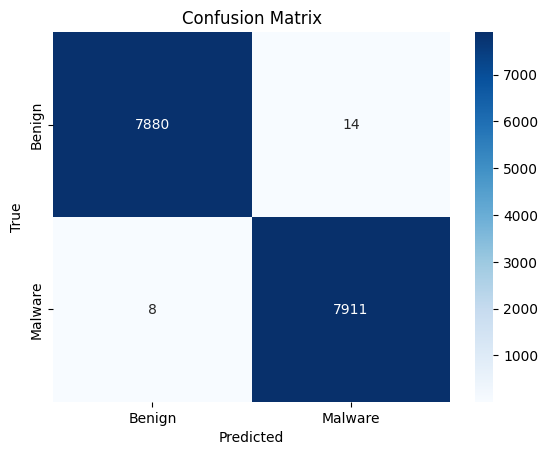

In [23]:
loss, acc , precision= model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


  1/495 ━━━━━━━━━━━━━━━━━━━━ 1:22 167ms/step - accuracy: 1.0000 - loss: 4.4325e-04 - recall: 1.0000

113/495 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9985 - loss: 0.0026 - recall: 0.9995      

296/495 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.9987 - loss: 0.0028 - recall: 0.9992

482/495 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.9989 - loss: 0.0026 - recall: 0.9993

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9989 - loss: 0.0026 - recall: 0.9993


Test Loss: 0.0019
Test Accuracy: 0.9992
Test precision: 0.9994


  1/495 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step

265/495 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



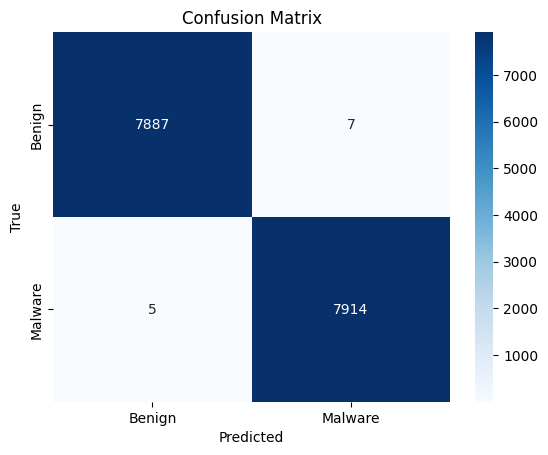

In [24]:
loss, acc , precision= lstm_bc.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (lstm_bc.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Save full model (preferred modern way)
model.save("global_FNN_model.keras")
lstm_bc.save("global_lstm_model.keras")